In [29]:
# iterative closest point
# inspired by http://stackoverflow.com/questions/20120384/iterative-closest-point-icp-implementation-on-python

In [30]:
import cv2
import numpy as np
import sys
from numpy.random import *

In [31]:
def del_miss(indeces, dist, max_dist, th_rate = 0.8):
    th_dist = max_dist * th_rate
    return np.array([indeces[0][np.where(dist.T[0] < th_dist)]])


In [32]:
def is_converge(Tr, scale):
    delta_angle = 0.0001
    delta_scale = scale * 0.0001

    min_cos = 1 - delta_angle
    max_cos = 1 + delta_angle
    min_sin = -delta_angle
    max_sin = delta_angle
    min_move = -delta_scale
    max_move = delta_scale

    return min_cos < Tr[0, 0] and Tr[0, 0] < max_cos and \
           min_cos < Tr[1, 1] and Tr[1, 1] < max_cos and \
           min_sin < -Tr[1, 0] and -Tr[1, 0] < max_sin and \
           min_sin < Tr[0, 1] and Tr[0, 1] < max_sin and \
           min_move < Tr[0, 2] and Tr[0, 2] < max_move and \
           min_move < Tr[1, 2] and Tr[1, 2] < max_move

In [33]:
def icp(d1, d2, max_iterate = 100):
    src = np.array([d1.T], copy=True).astype(np.float32)
    dst = np.array([d2.T], copy=True).astype(np.float32)

    knn = cv2.ml.KNearest_create()
    responses = np.array(range(len(d2[0]))).astype(np.float32)
    knn.train(src[0], cv2.ml.ROW_SAMPLE, responses)

    Tr = np.array([[np.cos(0), -np.sin(0), 0],
                   [np.sin(0), np.cos(0),  0],
                   [0,         0,          1]])

    dst = cv2.transform(dst, Tr[0:2])
    max_dist = sys.maxsize

    scale_x = np.max(d1[0]) - np.min(d1[0])
    scale_y = np.max(d1[1]) - np.min(d1[1])
    scale = max(scale_x, scale_y)

    for i in range(max_iterate):
        ret, results, neighbours, dist = knn.findNearest(dst[0], 1)

        indeces = results.astype(np.int32).T
        indeces = del_miss(indeces, dist, max_dist)

        T = cv2.estimateAffine2D(dst[0, indeces], src[0, indeces], True)[0]

        max_dist = np.max(dist)
        dst = cv2.transform(dst, T)
        Tr = np.dot(np.vstack((T,[0,0,1])), Tr)

        if (is_converge(T, scale)):
            break

    return Tr[0:2]

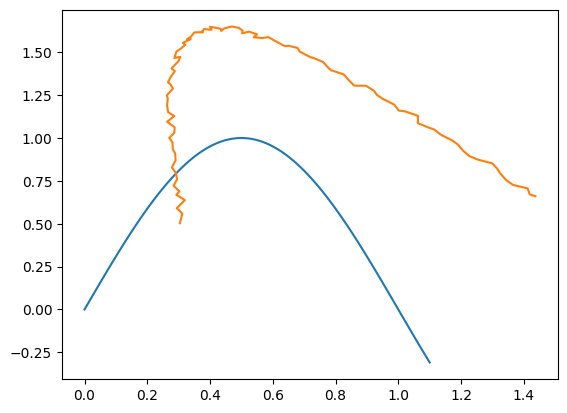

In [34]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    point_count = 100
    th = np.pi / 8
    move = np.array([[0.30], [0.5]])
    rnd_scale = 0.03
    x1 = np.linspace(0, 1.1, point_count)
    y1 = np.sin(x1 * np.pi)
    d1 = np.array([x1, y1])

    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    rand = np.random.rand(2, point_count)*rnd_scale
    d2 = np.dot(rot, d1) + move
    d2 = np.add(d2, rand)

    plt.plot(d1[0], d1[1])
    plt.plot(d2[0], d2[1])
    plt.show()

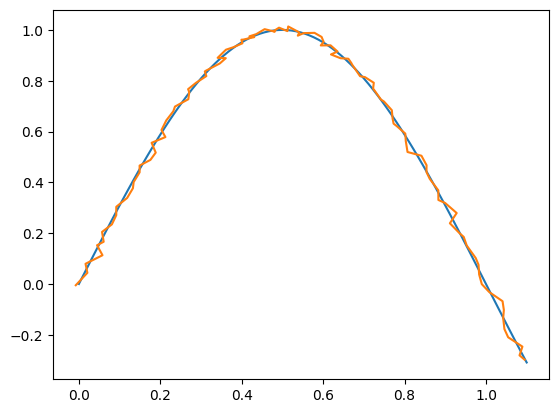

0.9910078068789615
22.959376515774853
22.23316973065288
[[ 0.92078166  0.37837673 -0.47782878]
 [-0.38677965  0.92164108 -0.35120719]]


In [35]:
    ret = icp(d1, d2)

    plt.plot(d1[0], d1[1])
    dst = np.array([d2.T], copy=True).astype(np.float32)
    dst = cv2.transform(dst, ret)
    plt.plot(dst[0].T[0], dst[0].T[1])
    plt.show()

    print(ret[0][0] * ret[0][0] + ret[0][1] * ret[0][1])
    print(np.arccos(ret[0][0]) / 2 / np.pi * 360)
    print(np.arcsin(ret[0][1]) / 2 / np.pi * 360)

    print(ret)